In [5]:
import pandas as pd
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import MetaTrader5 as mt5
import numpy as np
from sklearn.linear_model import LinearRegression
from arch.unitroot import ADF

,Date,Open,High,Low,Close,tick_volume,spread,real_volume,return,returnShift,M20,noTrend,lag1,lag2,alvo,z
21,2020-06-26,1.24182,1.24368,1.23144,1.23368,80719,0,0,-0.00818,-0.00383,1.254455,-0.020775,-0.012642,-0.011991,-0.023654,-2.000473
22,2020-06-29,1.23350,1.23896,1.22517,1.22985,75315,0,0,-0.00383,0.01021,1.253504,-0.023654,-0.020775,-0.012642,-0.012688,-2.204842
23,2020-06-30,1.22978,1.24018,1.22579,1.24006,79077,0,0,0.01021,0.00741,1.252748,-0.012688,-0.023654,-0.020775,-0.004776,-1.426441
24,2020-07-01,1.24009,1.24905,1.23593,1.24747,82446,0,0,0.00741,-0.00066,1.252246,-0.004776,-0.012688,-0.023654,-0.004797,-0.864796
25,2020-07-02,1.24747,1.25298,1.24563,1.24681,73744,0,0,-0.00066,0.00149,1.251607,-0.004797,-0.004776,-0.012688,-0.002387,-0.866251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,2021-02-26,1.40134,1.40259,1.38877,1.39270,157861,0,0,-0.00822,-0.00014,1.386693,0.006007,0.015365,0.029873,0.004555,-0.099314
195,2021-03-01,1.39248,1.39991,1.39040,1.39256,113235,0,0,-0.00014,0.00288,1.388005,0.004555,0.006007,0.015365,0.006000,-0.202386
196,2021-03-02,1.39257,1.39772,1.38590,1.39544,109595,0,0,0.00288,-0.00069,1.389440,0.006000,0.004555,0.006007,0.003786,-0.099811
197,2021-03-03,1.39512,1.40064,1.39209,1.39475,108886,0,0,-0.00069,-0.00546,1.390964,0.003786,0.006000,0.004555,-0.002785,-0.256975


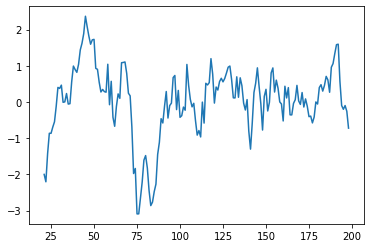

In [8]:
if not mt5.initialize(path="C:\Program Files\MetaTrader 5\\terminal64.exe"):
    print("initialize() failed, error code =", mt5.last_error())
    quit()
rates = mt5.copy_rates_from_pos("GBPUSD", mt5.TIMEFRAME_D1, 0 , 200)
a = pd.DataFrame(rates)
a['time'] = pd.to_datetime(a['time'], unit='s')
a.rename(columns={"time": "Date","open": "Open", "high": "High","low": "Low", "close": "Close" }, inplace=True)
a['return'] = a['Close'] - a['Close'].shift(1)
a['returnShift'] = a['return'].shift(-1)
a['M20'] = a['Close'].rolling(20).mean()
a['noTrend'] = a['Close'] - a['M20']
a['lag1'] = a['noTrend'].shift(1)
a['lag2'] = a['noTrend'].shift(2)
a['alvo'] = a['noTrend'].shift(-1)
media = a['noTrend'].mean()
dp = a['noTrend'].std()
a['z'] = (a['noTrend'] - media)/dp
a.dropna(inplace=True)
#print(a['z'].describe())
#print(sms.DescrStatsW(a['alvo']).tconfint_mean())
a['z'].plot()
a

count    178.000000
mean       0.000828
std        0.006818
min       -0.018960
25%       -0.003392
50%        0.001445
75%        0.005012
max        0.019910
Name: return, dtype: float64


<AxesSubplot:>

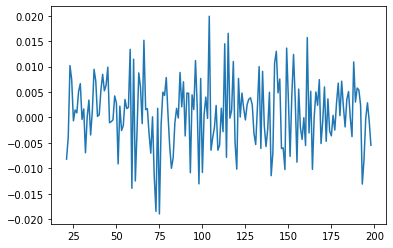

In [9]:
print(a['return'].describe())
a['return'].plot()


count    1.780000e+02
mean     2.962674e-17
std      1.000000e+00
min     -3.045450e+00
25%     -5.957424e-01
50%      2.224038e-02
75%      6.967292e-01
max      2.640713e+00
Name: z, dtype: float64


<AxesSubplot:>

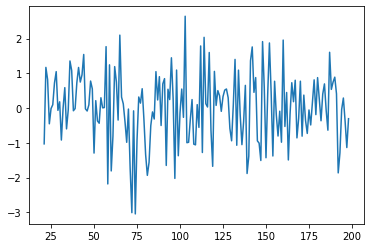

In [10]:
variaveis= ['noTrend','lag1', 'lag2']
x = a[variaveis]
y = a['alvo']
reg = LinearRegression().fit(x, y)
resultado = reg.predict(x)
a['previsao'] = resultado
a['residuos'] = a['alvo'] - resultado
media = a['residuos'].mean()
dp = a['residuos'].std()
a['z'] = (a['residuos'] - media)/dp
a.dropna(inplace=True)
print(a['z'].describe())
#print(sms.DescrStatsW(a['alvo']).tconfint_mean())
a['z'].plot()

In [11]:
a['Bull'] = np.select([a['z'] < -2], [(a['returnShift'])], default=0)

a['Bear'] = np.select([a['z'] > 2 ], [(- a['returnShift'])], default=0)

a['ResultCum'] = np.cumsum(a['Bull'] + a['Bear'])
a

,Date,Open,High,Low,Close,tick_volume,spread,real_volume,return,returnShift,...,noTrend,lag1,lag2,alvo,z,previsao,residuos,Bull,Bear,ResultCum
21,2020-06-26,1.24182,1.24368,1.23144,1.23368,80719,0,0,-0.00818,-0.00383,...,-0.020775,-0.012642,-0.011991,-0.023654,-1.029985,-0.017044,-0.006610,0.0,0.0,0.00000
22,2020-06-29,1.23350,1.23896,1.22517,1.22985,75315,0,0,-0.00383,0.01021,...,-0.023654,-0.020775,-0.012642,-0.012688,1.169444,-0.020193,0.007505,0.0,0.0,0.00000
23,2020-06-30,1.22978,1.24018,1.22579,1.24006,79077,0,0,0.01021,0.00741,...,-0.012688,-0.023654,-0.020775,-0.004776,0.818822,-0.010031,0.005255,0.0,0.0,0.00000
24,2020-07-01,1.24009,1.24905,1.23593,1.24747,82446,0,0,0.00741,-0.00066,...,-0.004776,-0.012688,-0.023654,-0.004797,-0.453264,-0.001888,-0.002909,0.0,0.0,0.00000
25,2020-07-02,1.24747,1.25298,1.24563,1.24681,73744,0,0,-0.00066,0.00149,...,-0.004797,-0.004776,-0.012688,-0.002387,-0.015320,-0.002288,-0.000098,0.0,0.0,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,2021-02-26,1.40134,1.40259,1.38877,1.39270,157861,0,0,-0.00822,-0.00014,...,0.006007,0.015365,0.029873,0.004555,-0.042431,0.004827,-0.000272,0.0,0.0,-0.11604
195,2021-03-01,1.39248,1.39991,1.39040,1.39256,113235,0,0,-0.00014,0.00288,...,0.004555,0.006007,0.015365,0.006000,0.288130,0.004151,0.001849,0.0,0.0,-0.11604
196,2021-03-02,1.39257,1.39772,1.38590,1.39544,109595,0,0,0.00288,-0.00069,...,0.006000,0.004555,0.006007,0.003786,-0.374768,0.006191,-0.002405,0.0,0.0,-0.11604
197,2021-03-03,1.39512,1.40064,1.39209,1.39475,108886,0,0,-0.00069,-0.00546,...,0.003786,0.006000,0.004555,-0.002785,-1.136322,0.004507,-0.007292,0.0,0.0,-0.11604


count    178.000000
mean      -0.075064
std        0.047659
min       -0.116040
25%       -0.116040
50%       -0.099480
75%       -0.029100
max        0.000000
Name: ResultCum, dtype: float64


<AxesSubplot:>

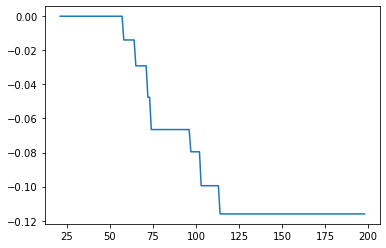

In [12]:
print(a['ResultCum'].describe())
a['ResultCum'].plot()

In [13]:
adf = ADF(a['residuos'])
print(adf.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                -13.514
P-value                         0.000
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -3.47 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
